In [1]:
import numpy as np
from scipy.stats import zscore
import matplotlib as mpl
from matplotlib import pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

import torch
from torch import nn, optim
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.io import loadmat
import os, sys
import torchvision.transforms as transforms
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform
import pandas as pd
from scipy.special import comb

# images = loadmat('baoimg.mat').get('img')
%run clean_cornets.py

In [2]:
from torchvision import datasets, transforms

# data_dir = 'images/'
data_dir = 'stimuli/mirrorwords/'
transform = {'train': transforms.Compose([transforms.Resize((224,224)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),}

chosen_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform[x]) for x in ['train']}
dataloaders = {x: torch.utils.data.DataLoader(chosen_datasets[x], batch_size = 800) for x in ['train']}
images, classes = next(iter(dataloaders['train']))

np.shape(images)

torch.Size([744, 3, 224, 224])

In [ ]:
import torchvision

grid = torchvision.utils.make_grid(images)
plt.figure(figsize = (10,100))
plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')


In [3]:
stimtemp = images[:,:,:,:]

# Loading all the three network and extracting representation from all the hidden units
ili = {}
net = CORnet_Z_tweak()
checkpoint = torch.load('models/save_illit_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)
# ili['v1'], ili['v2'], ili['v4'], ili['it'], ili['h'],  ili['out'] = net(stimtemp.float())
ili['v1'], ili['v2'], ili['v4'], ili['it'], ili['h'],  ili['out'] = net(stimtemp.float())

# Bli = {}
# net = CORNet_Z_biased_words()
# checkpoint = torch.load('models/save_lit_bias_z_79_full_nomir.pth.tar')['state_dict']
# for key in list(checkpoint.keys()):
#     if 'module.' in key:
#         checkpoint[key.replace('module.', '')] = checkpoint[key]
#         del checkpoint[key]
# net.load_state_dict(checkpoint)
# Bli['v1'], Bli['v2'], Bli['v4'], Bli['it'], Bli['h'],  Bli['out'] = net(stimtemp.float())


nBli = {}
net = CORNet_Z_nonbiased_words()
checkpoint = torch.load('models/save_lit_no_bias_z_79_full_nomir.pth.tar')['state_dict']
for key in list(checkpoint.keys()):
    if 'module.' in key:
        checkpoint[key.replace('module.', '')] = checkpoint[key]
        del checkpoint[key]
net.load_state_dict(checkpoint)

nBli['v1'], nBli['v2'], nBli['v4'], nBli['it'], nBli['h'],  nBli['out'] = net(stimtemp.float())

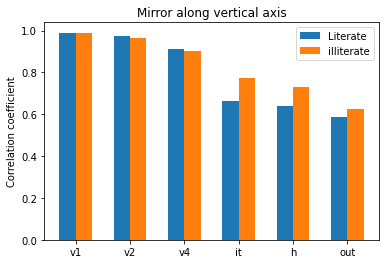

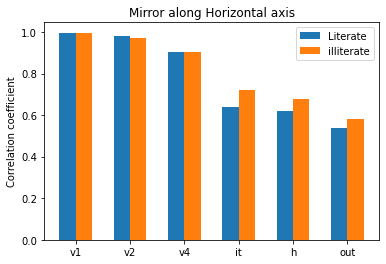

In [130]:
# Population level analysis
from sklearn.utils import resample
from scipy.stats import spearmanr

roi_ID = ['v1', 'v2', 'v4','it','h','out']; distMetric = 'l1'
rval_lit_h = np.zeros((6)); rval_lit_v = np.zeros((6))
rval_ili_h = np.zeros((6)); rval_ili_v = np.zeros((6))

for idx in range(len(roi_ID)):
    D = np.zeros((comb(np.size(stimtemp[::3,:],0), 2,exact =True),3)); 
    resp = ili[roi_ID[idx]].detach().numpy()
    respid= np.where(np.mean(resp,0) !=0)[0]    
    D[:,0] = squareform(pairwise_distances(resp[::3,respid],metric = distMetric))
    D[:,1] = squareform(pairwise_distances(resp[1::3,respid],metric = distMetric))
    D[:,2] = squareform(pairwise_distances(resp[2::3,respid],metric = distMetric))
    rval_ili_v[idx],_ = spearmanr(D[:,0],D[:,1])
    rval_ili_h[idx],_ = spearmanr(D[:,0],D[:,2])
    
    
    D = np.zeros((comb(np.size(stimtemp[::3,:],0), 2,exact =True),3)); 
    resp = nBli[roi_ID[idx]].detach().numpy()
    respid= np.where(np.mean(resp,0) !=0)[0]    
    D[:,0] = squareform(pairwise_distances(resp[::3,respid],metric = distMetric))
    D[:,1] = squareform(pairwise_distances(resp[1::3,respid],metric = distMetric))
    D[:,2] = squareform(pairwise_distances(resp[2::3,respid],metric = distMetric))
    rval_lit_v[idx],_ = spearmanr(D[:,0],D[:,1])
    rval_lit_h[idx],_ = spearmanr(D[:,0],D[:,2])
    
    
plt.figure(1);  plt.bar(np.arange(6)-.15,rval_lit_v, width = 0.3); plt.bar(np.arange(6)+.15,rval_ili_v, width = 0.3)
plt.xticks(ticks = range(6),labels = roi_ID);
plt.ylabel('Correlation coefficient'); plt.title('Mirror along vertical axis')
plt.legend(['Literate','illiterate'])

plt.figure(2);  plt.bar(np.arange(6)-.15,rval_lit_h, width = 0.3); plt.bar(np.arange(6)+.15,rval_ili_h, width = 0.3)
plt.xticks(ticks = range(6),labels = roi_ID);
plt.ylabel('Correlation coefficient'); plt.title('Mirror along Horizontal axis')
plt.legend(['Literate','illiterate'])

In [107]:
# Mirror invariance for each unit

from scipy.stats import pearsonr

roi_ID = ['v1', 'v2', 'v4','it','h','out']; 
mean_rili_v = []; mean_rili_h = []; mean_rlit_v = []; mean_rlit_h = [];
std_rili_v = []; std_rili_h = []; std_rlit_v = []; std_rlit_h = [];

for roi in roi_ID:
    resp_ili = ili[roi].detach().numpy()
    resp_lit = nBli[roi].detach().numpy()
    rili_v = np.zeros((np.shape(resp_ili)[1]))
    rili_h = np.zeros((np.shape(resp_ili)[1]));
    rlit_v = np.zeros((np.shape(resp_ili)[1]));
    rlit_h = np.zeros((np.shape(resp_ili)[1]));

    for idx in range(np.shape(resp_ili)[1]):
        rili_v[idx],_ = pearsonr(resp_ili[::3,idx],resp_ili[1::3,idx])
        rili_h[idx],_ = pearsonr(resp_ili[::3,idx],resp_ili[2::3,idx])

        rlit_v[idx],_ = pearsonr(resp_lit[::3,idx],resp_lit[1::3,idx])
        rlit_h[idx],_ = pearsonr(resp_lit[::3,idx],resp_lit[2::3,idx])

    #   Saving mean values
    mean_rili_v.append(np.nanmean(rili_v)); std_rili_v.append(np.nanstd(rili_v));
    mean_rili_h.append(np.nanmean(rili_h)); std_rili_h.append(np.nanstd(rili_h));

    mean_rlit_v.append(np.nanmean(rlit_v)); std_rlit_v.append(np.nanstd(rlit_v));
    mean_rlit_h.append(np.nanmean(rlit_h)); std_rlit_h.append(np.nanstd(rlit_h));


plt.figure(1);  
plt.bar(np.arange(6)-.15,mean_rlit_v, width = 0.3); plt.bar(np.arange(6)+.15,mean_rili_v, width = 0.3);
plt.xticks(ticks = range(6),labels = roi_ID);
plt.ylabel('Correlation coefficient'); plt.title('Mirror along vertical axis')
plt.legend(['Literate','illiterate'])

plt.figure(2);  plt.bar(np.arange(6)-.15,mean_rlit_h, width = 0.3); plt.bar(np.arange(6)+.15,mean_rili_h, width = 0.3)
plt.xticks(ticks = range(6),labels = roi_ID);
plt.ylabel('Correlation coefficient'); plt.title('Mirror along Horizontal axis')
plt.legend(['Literate','illiterate'])